In [1]:
# Determine quality os wines
# Parametric experiment determine the effect of minibatchs
# Resullts - Epoch x Accuracy for train and test
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)


In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.stats import zscore
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


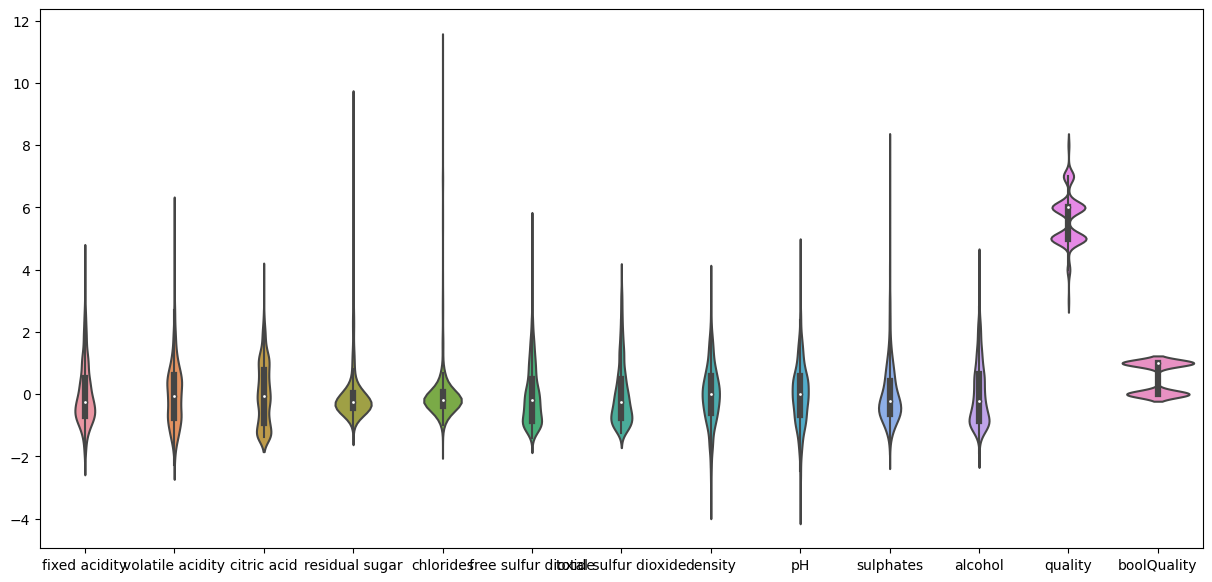

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")

data = data[data["total sulfur dioxide"] < 200].copy()
cols2zscore = data.columns.drop("quality").to_list()
data[cols2zscore] = data[cols2zscore].apply(zscore).copy()
# data["quality"] = data["quality"]-min(data["quality"])

data["boolQuality"] = 0
data.loc[data["quality"] > 5, "boolQuality"] = 1

plt.figure(figsize=(15, 7))
sns.violinplot(data=data, orient="v")
plt.show()
plt.close()


In [4]:
tensor_data = torch.tensor(data[cols2zscore].values).float()
tensor_labels = torch.tensor(data["boolQuality"].values.reshape((-1, 1))).float()


In [5]:
train_size = 0.9
train_data, test_data, train_labels, test_labels = train_test_split(
    tensor_data, tensor_labels, train_size=train_size, shuffle=True
)


In [6]:
def extract_loader(train_data, train_labels, test_data, test_labels, batch_size=16):
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, drop_last=True
    )
    test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    return train_loader, test_loader


In [7]:
class ANNWine(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(11, 16)
        self.layer1 = nn.Linear(16, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output(x)


In [8]:
def compute_acc(y_hat, y):
    return torch.mean(((y_hat > 0) == y).float()).item()
    # return torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()


In [9]:
def test_ANN(ANN, test_loader):
    with torch.no_grad():
        X, y = test_loader.dataset.tensors
        y_hat = ANN(X)
    return compute_acc(y_hat, y)


In [10]:
def train_ANN(ANN, lossfun, optimizer, epochs, train_loader, test_loader):
    train_acc = []
    test_acc = []
    losses = []

    for epoch in range(epochs):
        batch_loss = []
        batch_acc = []
        ANN.train()

        for X, y in train_loader:
            y_hat = ANN(X)
            loss = lossfun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append(compute_acc(y_hat, y))
            batch_loss.append(loss.item())

        ANN.eval()
        test_acc.append(test_ANN(ANN, test_loader))
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))

    return train_acc, test_acc, losses


In [11]:
batch_size = 8
train_loader, test_loader = extract_loader(
    train_data, train_labels, test_data, test_labels, batch_size
)

net = ANNWine()
# lossfun = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=0.001)

lossfun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)


In [12]:
train_acc, test_acc, loss = train_ANN(
    net, lossfun, optimizer, 2000, train_loader, test_loader
)


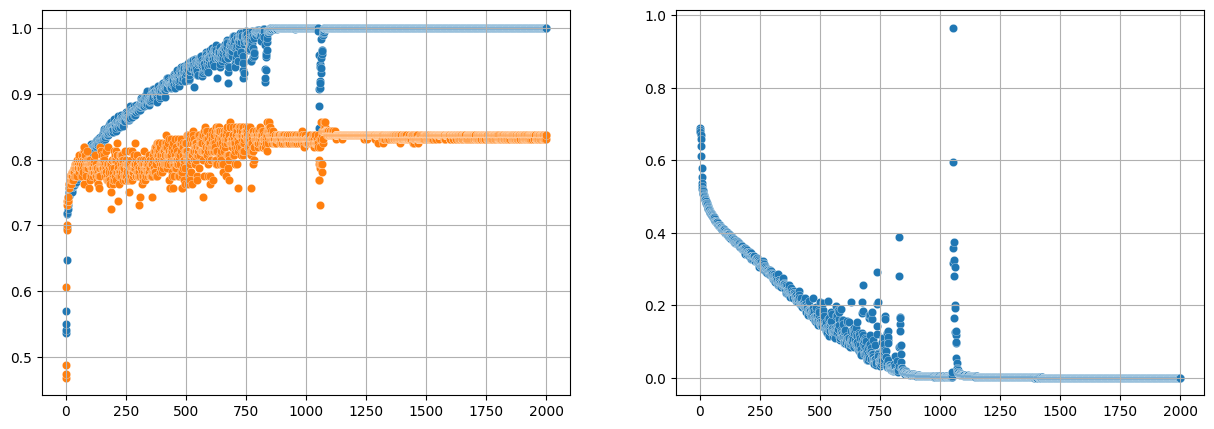

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=train_acc, linewidth=0.2, ax=ax[0])
sns.scatterplot(data=test_acc, linewidth=0.2, ax=ax[0])
ax[0].grid()
sns.scatterplot(data=loss, linewidth=0.2, ax=ax[1])
ax[1].grid()
plt.show()
plt.close()
